# List 3 of Machine Learning course

## Introduction

This notebook is part of the Machine Learning course and focuses on the implementation and evaluation of decision tree classifiers. The notebook covers various aspects of data preprocessing, model training, and hyperparameter tuning. It includes steps for loading and cleaning the dataset, and performing exploratory data analysis (EDA). The notebook also explores different hyperparameters such as max depth, criterion, min samples leaf, and class weight, and their impact on the performance of the decision tree model. Visualizations are provided to help understand the effects of these parameters on the model's performance.

**The goal** of the notebook is to analyse the Classification and Regression Trees (CART) algorithm, currently one of the most widely used implementations of decision trees.

Dataset: [Secondary Mushroom](https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset)


## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import graphviz
import sweetviz as sv

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.experimental import enable_halving_search_cv
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix, f1_score,
                             make_scorer, matthews_corrcoef, precision_score,
                             recall_score)
from sklearn.model_selection import StratifiedKFold, train_test_split, HalvingGridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree as sktree
from ucimlrepo import fetch_ucirepo

d:\Anaconda\envs\PGM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Loading

In [3]:
# fetch dataset 
secondary_mushroom = fetch_ucirepo(id=848) 
  
# data (as pandas dataframes) 
X = secondary_mushroom.data.features 
y = secondary_mushroom.data.targets 
  
display(X.head())
display(y.head())

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,15.26,x,g,o,f,e,NaN,w,16.95,17.09,s,y,w,u,w,t,g,NaN,d,w
1,16.60,x,g,o,f,e,NaN,w,17.99,18.19,s,y,w,u,w,t,g,NaN,d,u
2,14.07,x,g,o,f,e,NaN,w,17.80,17.74,s,y,w,u,w,t,g,NaN,d,w
3,14.17,f,h,e,f,e,NaN,w,15.77,15.98,s,y,w,u,w,t,p,NaN,d,w
4,14.64,x,h,o,f,e,NaN,w,16.53,17.20,s,y,w,u,w,t,p,NaN,d,w


,class
0,p
1,p
2,p
3,p
4,p


## Train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## Auto EDA

In [5]:
y['class'].unique()

array(['p', 'e'], dtype=object)

In [6]:
df_y = y_train.replace({'p': 1, 'e': 0})  # Its important because of sweetviz
df_train = pd.concat([X_train, df_y], axis=1)

C:\Users\dawir\AppData\Local\Temp\ipykernel_4044\4196538143.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_y = y_train.replace({'p': 1, 'e': 0})  # Its important because of sweetviz


In [7]:
report = False
if report:
    sweet_report = sv.analyze(df_train, target_feat='class')
    sweet_report.show_html('sweetviz_report.html')

### Conclusions:

1. we have a good balance of classes: 55% to 45%.
2. `veil-type` - has only one unique value and is missing 95% (out).
3. `veil-color` - although it separates nicely overall is a very empty 88% (out).
4. `spore-print-color` 85%, `stem-root` 84%, `stem-surface` 62% - have little data, lots of missing values, but I'll leave it and let the dimensionality reduction method determine if it's meaningless.
5. `stem-width` and `cap-diameter` have a high correlation of 0.7 (they can probably be substituted for each other).
6. `has-ring` and `ring-type` have a high correlation of 0.72..
7. `stem-width`, `cap-diameter`, `step-height` have strong outliers.
8. `does-bruise-or-bleed` seems individually insignificant.

The numeric data have no missing data, so missing data (in categorical variables only) will be converted to the ‘nan’ category.

Just in case the numerical test data has gaps, the answer is the median from the training variables. Because the mean can be shifted by outliers.

After analysing the graph, I also decided on a 3% cut-off of outliers. because there are about that many ‘by eye’.


## Utility Classes and Functions

In [8]:
def replace_nans(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df.loc[:, col] = df[col].fillna('nan')
        else:
            df.loc[:, col] = df[col].fillna(df[col].median())
    return df

In [9]:
class CustomEncoder(TransformerMixin, BaseEstimator):
    def __init__(self):
        self.encoding_dict = {}

    def fit(self, X, y=None):
        for column in X.columns:
            unique_values = X[column].unique()
            self.encoding_dict[column] = {value: i for i, value in enumerate(unique_values)}
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for column in X.columns:
            X_transformed[column] = X[column].map(self.encoding_dict[column])
        return X_transformed
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

In [10]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, contamination=0.03):
        self.contamination = contamination
        self.clf = IsolationForest(n_estimators=100, contamination=self.contamination, random_state=42)

    def fit(self, X, y=None):
        self.clf.fit(X)
        return self

    def transform(self, X, y=None):
        outliers = self.clf.predict(X)
        if y is None:
            return X[outliers == 1]
        else:
            return X[outliers == 1], y[outliers == 1]
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X, y)

## Data Cleaning

<div class="alert alert-info">
  <strong>Note:</strong>
  Trees are not sensitive to the range of data hence normalisation and standardisation are unnecessary. Additionally, text data should be accepted by trees, but sklearn only allows numeric data, so encoding is needed.
</div>

In [11]:
drop_columns = ['veil-type', 'veil-color']

X_train_clean = X_train.drop(columns=drop_columns)
X_test_clean = X_test.drop(columns=drop_columns)

In [12]:
X_train_clean = replace_nans(X_train_clean)
X_test_clean = replace_nans(X_test_clean)

In [13]:
encoder = CustomEncoder()
categories = X_train_clean.select_dtypes(include='object').columns
X_train_clean[categories] = encoder.fit_transform(X_train_clean[categories])
X_test_clean[categories] = encoder.transform(X_test_clean[categories])

In [14]:
isf = IsolationForest(contamination=0.03)
numeric_columns = X_train_clean.select_dtypes(include=[np.float64]).columns
isf.fit(X_train_clean[numeric_columns])
outliers = isf.predict(X_train_clean[numeric_columns])

X_train_no_outliers = X_train_clean[outliers == 1]
y_train_no_outliers = y_train[outliers == 1]

outliers = isf.predict(X_test_clean[numeric_columns])
X_test_no_outliers = X_test_clean[outliers == 1]
y_test_no_outliers = y_test[outliers == 1]

In [15]:
y_train_no_outliers = y_train_no_outliers.replace({'p': 1, 'e': 0})
y_test_no_outliers = y_test_no_outliers.replace({'p': 1, 'e': 0})

C:\Users\dawir\AppData\Local\Temp\ipykernel_4044\2262167500.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train_no_outliers = y_train_no_outliers.replace({'p': 1, 'e': 0})
C:\Users\dawir\AppData\Local\Temp\ipykernel_4044\2262167500.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test_no_outliers = y_test_no_outliers.replace({'p': 1, 'e': 0})


## Basic Tree

In [16]:
results = {}

In [17]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_no_outliers, y_train_no_outliers)
y_pred = tree.predict(X_test_no_outliers)

results['SimpleTree'] = {
    'recall': recall_score(y_test_no_outliers, y_pred, pos_label=1),
    'precision': precision_score(y_test_no_outliers, y_pred, pos_label=1),
    'f1': f1_score(y_test_no_outliers, y_pred, pos_label=1),
    'accuracy': accuracy_score(y_test_no_outliers, y_pred),
    'mcc': matthews_corrcoef(y_test_no_outliers, y_pred)
    }

results_df = pd.DataFrame(results)

display(results_df)

,SimpleTree
recall,0.997525
precision,0.997624
f1,0.997575
accuracy,0.997241
mcc,0.994376


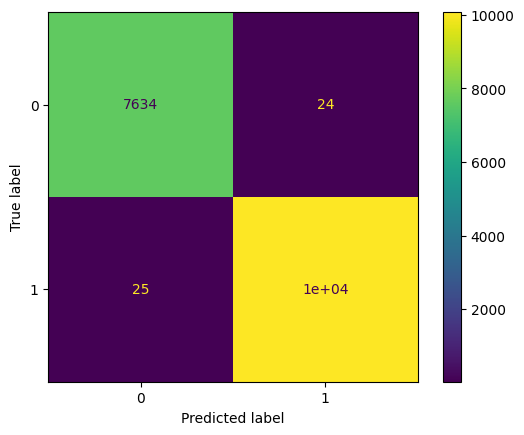

In [18]:
cm = confusion_matrix(y_test_no_outliers, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree.classes_)
disp.plot()

In [19]:
X_train_no_outliers.columns

Index(['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season'],
      dtype='object')

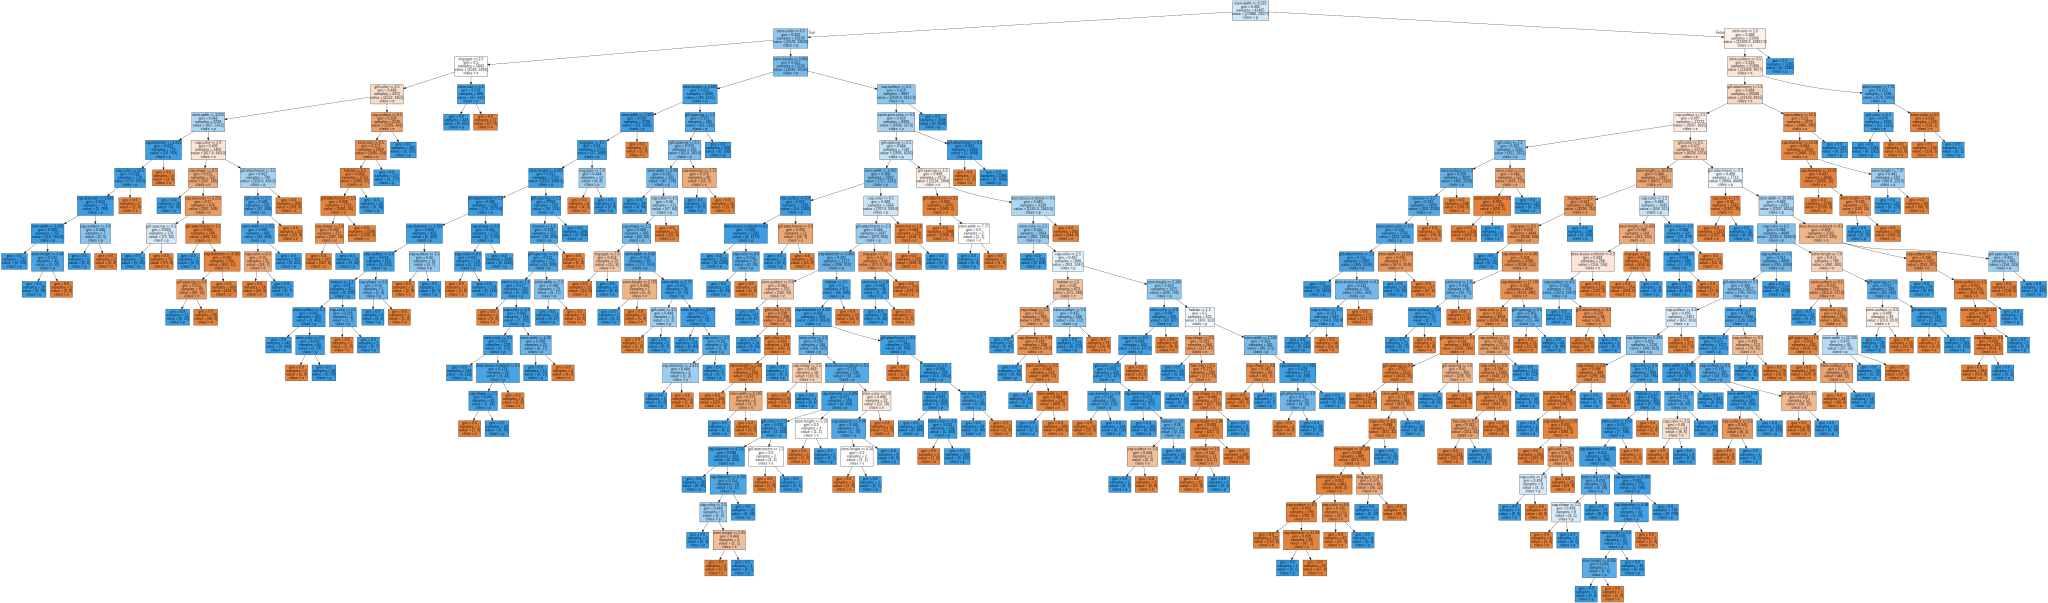

In [29]:
graph_tree = sktree.export_graphviz(tree, out_file=None, feature_names=list(X_train_no_outliers.columns),
                                    class_names=['e', 'p'], filled=True)
graph = graphviz.Source(graph_tree, format='png')
display(graph)

## Utility Pipelines

### PCA

In [30]:
drop_columns = ['veil-type', 'veil-color']

X_train_clean = X_train.drop(columns=drop_columns)
X_test_clean = X_test.drop(columns=drop_columns)

In [31]:
categorical_columns = X_train_clean.select_dtypes(include=['object']).columns
float_columns = X_train_clean.select_dtypes(include=[np.float64]).columns

colum_preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', CustomEncoder(), categorical_columns),
        ('minmax', MinMaxScaler(), float_columns)
    ], remainder='passthrough')

pca_pipeline = Pipeline(steps=[
    ('transformer', FunctionTransformer(replace_nans)),
    ('preprocessor', colum_preprocessor),
    ('isolation_forest', OutlierRemover()),
    ('pca', PCA(n_components=None))
])

In [32]:
pca_pipeline

Pipeline(steps=[('transformer',
                 FunctionTransformer(func=<function replace_nans at 0x000001EEA908DAB0>)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder', CustomEncoder(),
                                                  Index(['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed',
       'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root',
       'stem-surface', 'stem-color', 'has-ring', 'ring-type',
       'spore-print-color', 'habitat', 'season'],
      dtype='object')),
                                                 ('minmax', MinMaxScaler(),
                                                  Index(['cap-diameter', 'stem-height', 'stem-width'], dtype='object'))])),
                ('isolation_forest', OutlierRemover()), ('pca', PCA())])

In [33]:
pca_pipeline.fit(X_train_clean)
pca = pca_pipeline.named_steps['pca']
pca.explained_variance_ratio_

array([2.42887342e-01, 1.78312969e-01, 1.59359885e-01, 9.60553482e-02,
       8.83378541e-02, 6.00242959e-02, 4.58144146e-02, 3.84294264e-02,
       2.79830701e-02, 1.79357260e-02, 1.63575533e-02, 1.27992445e-02,
       1.11607367e-02, 2.63149209e-03, 1.53502747e-03, 2.52291480e-04,
       8.80213149e-05, 3.53014936e-05])

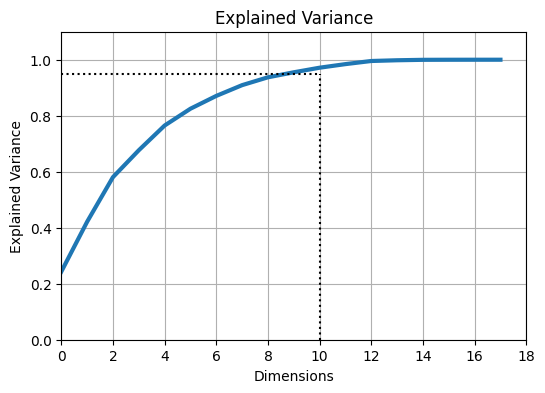

PCA osiąga ponad 0.95% wariancji dla 10 wymiarów


In [ ]:
# source: https://github.com/ageron/handson-ml2/blob/master/08_dimensionality_reduction.ipynb
reduction_factor = 0.95

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= reduction_factor) + 1

plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, len(X_train_clean.columns), 0, 1.1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, reduction_factor], "k:")
plt.plot([0, d], [reduction_factor, reduction_factor], "k:")
plt.grid(True)
plt.title("Explained Variance")
plt.show()
print(f"PCA achieves more than {reduction_factor}% variance for {d} dimensions")

### Three with pipeline

In [35]:
drop_columns = ['veil-type', 'veil-color']

X_train_clean = X_train.drop(columns=drop_columns)
X_test_clean = X_test.drop(columns=drop_columns)

y_train_clean = y_train.replace({'p': 1, 'e': 0})
y_test_clean = y_test.replace({'p': 1, 'e': 0})

C:\Users\dawir\AppData\Local\Temp\ipykernel_4044\2509664566.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train_clean = y_train.replace({'p': 1, 'e': 0})
C:\Users\dawir\AppData\Local\Temp\ipykernel_4044\2509664566.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test_clean = y_test.replace({'p': 1, 'e': 0})


In [36]:
categorical_columns = X_train_clean.select_dtypes(include=['object']).columns
float_columns = X_train_clean.select_dtypes(include=[np.float64]).columns

colum_preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', CustomEncoder(), categorical_columns),
        ('minmax', MinMaxScaler(), float_columns)
    ], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('transformer', FunctionTransformer(replace_nans)),
    ('preprocessor', colum_preprocessor),
    # ('isolation_forest', OutlierRemover()),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('tree', DecisionTreeClassifier(random_state=42))
])

In [37]:
pipeline.fit(X_train_clean, y_train_clean)
y_pred = pipeline.predict(X_test_clean)

results['PipelineTree'] = {
    'recall': recall_score(y_test_clean, y_pred, pos_label=1),
    'precision': precision_score(y_test_clean, y_pred, pos_label=1),
    'f1': f1_score(y_test_clean, y_pred, pos_label=1),
    'accuracy': accuracy_score(y_test_clean, y_pred),
    'mcc': matthews_corrcoef(y_test_clean, y_pred)
    }

results_df = pd.DataFrame(results)

display(results_df)

,SimpleTree,PipelineTree
recall,0.997525,0.999115
precision,0.997624,0.999213
f1,0.997575,0.999164
accuracy,0.997241,0.999072
mcc,0.994376,0.998122


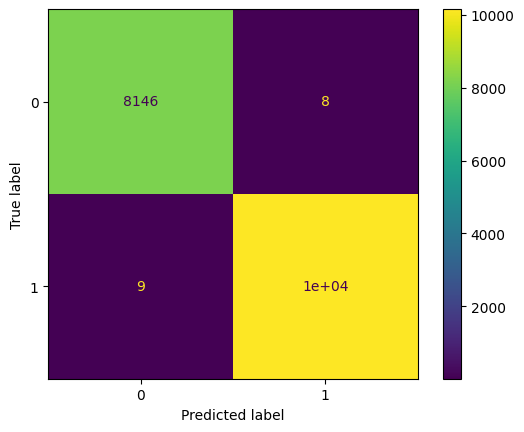

In [38]:
cm = confusion_matrix(y_test_clean, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.named_steps['tree'].classes_)
disp.plot()

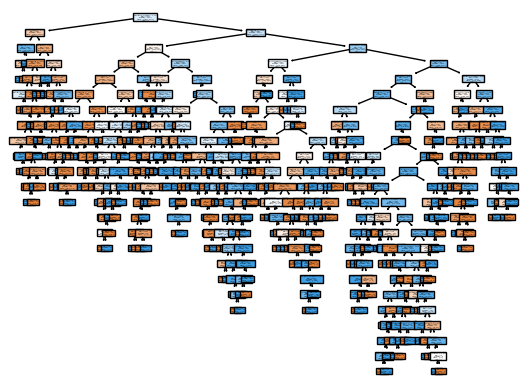

In [39]:
plot_tree(pipeline.named_steps['tree'], filled=True, feature_names=X_train_clean.columns, class_names={1: 'p', 0: 'e'})
plt.show()

#### Pipeline no outliers

In [40]:
isf = IsolationForest(contamination=0.03, random_state=42)
numeric_columns = X_train_clean.select_dtypes(include=[np.float64]).columns
isf.fit(X_train_clean[numeric_columns])
outliers = isf.predict(X_train_clean[numeric_columns])

X_train_no_outliers = X_train_clean[outliers == 1]
y_train_no_outliers = y_train_clean[outliers == 1]

outliers = isf.predict(X_test_clean[numeric_columns])
X_test_no_outliers = X_test_clean[outliers == 1]
y_test_no_outliers = y_test_clean[outliers == 1]

In [41]:
pipeline.fit(X_train_no_outliers, y_train_no_outliers)
y_pred = pipeline.predict(X_test_no_outliers)

results['PipelineTreeNoOutliers'] = {
    'recall': recall_score(y_test_no_outliers , y_pred, pos_label=1),
    'precision': precision_score(y_test_no_outliers , y_pred, pos_label=1),
    'f1': f1_score(y_test_no_outliers , y_pred, pos_label=1),
    'accuracy': accuracy_score(y_test_no_outliers , y_pred),
    'mcc': matthews_corrcoef(y_test_no_outliers , y_pred)
    }

results_df = pd.DataFrame(results)

display(results_df)

,SimpleTree,PipelineTree,PipelineTreeNoOutliers
recall,0.997525,0.999115,0.999107
precision,0.997624,0.999213,0.999305
f1,0.997575,0.999164,0.999206
accuracy,0.997241,0.999072,0.999098
mcc,0.994376,0.998122,0.998163


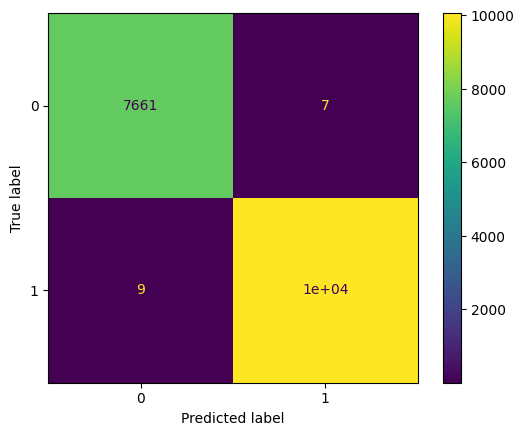

In [42]:
cm = confusion_matrix(y_test_no_outliers, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.named_steps['tree'].classes_)
disp.plot()

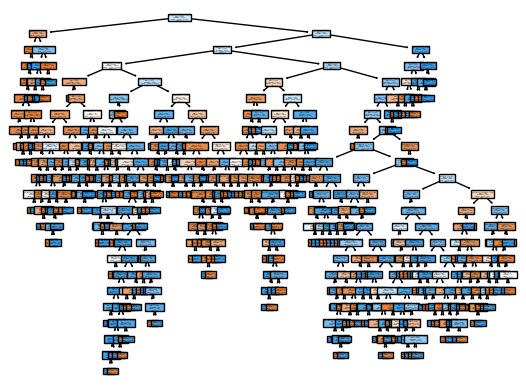

In [43]:
plot_tree(pipeline.named_steps['tree'], filled=True, feature_names=X_train_clean.columns, class_names={1: 'p', 0: 'e'})
plt.show()

## Consideration of parameters

<div class="alert alert-info">
  <strong>Note:</strong>
  We will only look at one measure and that is <strong><i>recall</i></strong>. We want above all not to poison people.
</div>

### Max Depth

In [44]:
pipeline.named_steps['tree'].get_depth()

22

In [45]:
grid_params = {'tree__max_depth': [9, 11, 13, 15, 17, 19, 21],}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

depth_search = HalvingGridSearchCV(pipeline, grid_params, cv=cv, scoring='recall', n_jobs=-1, random_state=42)
depth_search.fit(X_train_clean, y_train_clean['class'])

df = {
    'max_depth': depth_search.cv_results_['param_tree__max_depth'].data,
    'recall': depth_search.cv_results_['mean_test_score']
}
df = pd.DataFrame(df)
df = df.groupby('max_depth').mean().reset_index()
display(df)

,max_depth,recall
0,9,0.850687
1,11,0.926291
2,13,0.961603
3,15,0.983448
4,17,0.992014
5,19,0.994078
6,21,0.994667


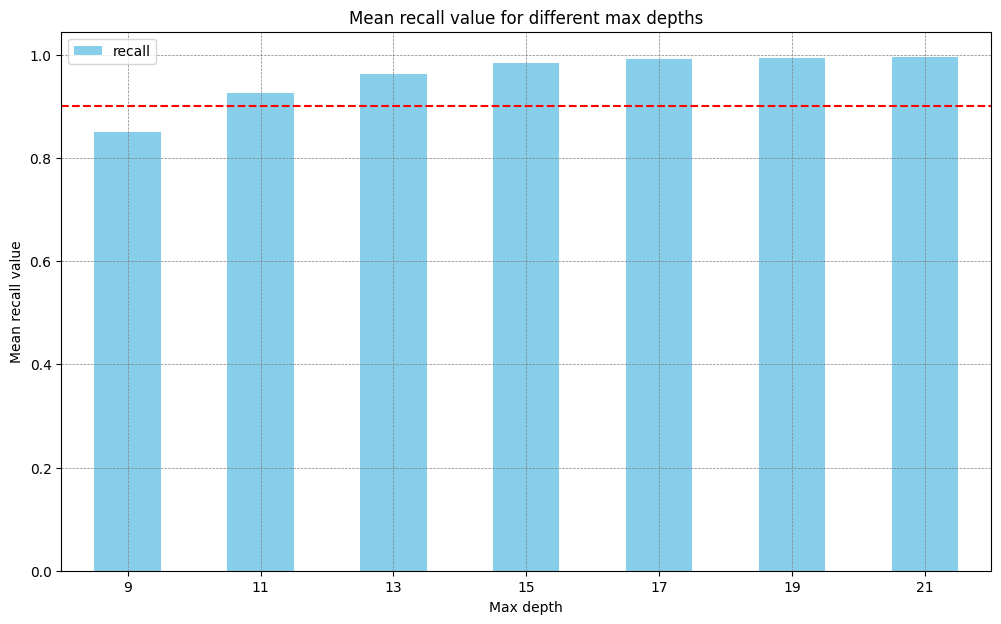

In [46]:
df.plot(x='max_depth', y=['recall'], kind='bar', figsize=(12, 7), color='skyblue')
plt.title('Mean recall value for different max depths')
plt.xlabel('Max depth')
plt.ylabel('Mean recall value')
plt.axhline(0.9, c='r', label='0.9 threshold', linestyle='--')
plt.xticks(rotation=0)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

<div class="alert alert-warning">
  <strong>Uwaga:</strong>
  It is apparent that outliers have a lot of ‘causal power’, their absence quickly converting the results in the model to Nan.
</div>

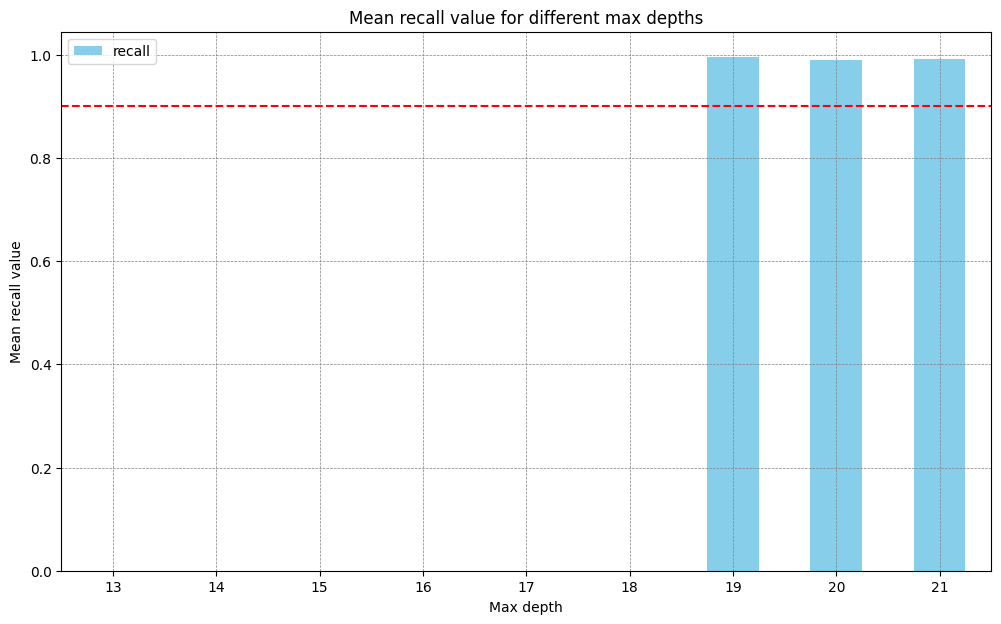

### Visualisation for a shallow tree

In [47]:
pipeline_copy = clone(pipeline)
pipeline_copy.set_params(tree__max_depth=7)
pipeline_copy.fit(X_train_clean, y_train_clean['class'])

y_pred = pipeline_copy.predict(X_test_clean)

results['ShallowTree'] = {
    'recall': recall_score(y_test_clean , y_pred, pos_label=1),
    'precision': precision_score(y_test_clean , y_pred, pos_label=1),
    'f1': f1_score(y_test_clean , y_pred, pos_label=1),
    'accuracy': accuracy_score(y_test_clean , y_pred),
    'mcc': matthews_corrcoef(y_test_clean, y_pred)
    }

results_df = pd.DataFrame(results)

display(results_df)

,SimpleTree,PipelineTree,PipelineTreeNoOutliers,ShallowTree
recall,0.997525,0.999115,0.999107,0.942559
precision,0.997624,0.999213,0.999305,0.816895
f1,0.997575,0.999164,0.999206,0.875240
accuracy,0.997241,0.999072,0.999098,0.850882
mcc,0.994376,0.998122,0.998163,0.703274


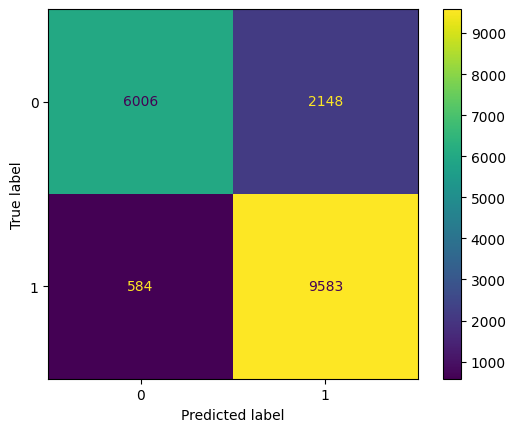

In [48]:
cm = confusion_matrix(y_test_clean, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_copy.named_steps['tree'].classes_)
disp.plot()

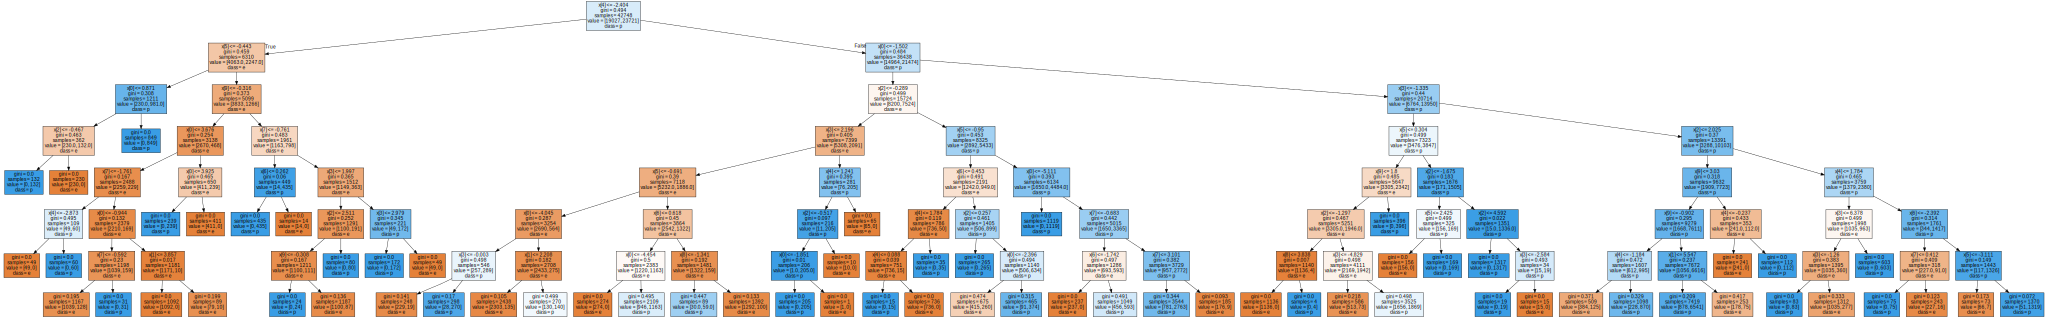

In [51]:
graph_tree = sktree.export_graphviz(pipeline_copy.named_steps['tree'], out_file=None, class_names=['e', 'p'], filled=True)
graph = graphviz.Source(graph_tree, format='png')
display(graph)

### Criterion

In [52]:
grid_params = {'tree__criterion': ['gini', 'entropy', 'log_loss'], 'tree__max_depth': [13]}

criterion_search = HalvingGridSearchCV(pipeline, grid_params, cv=cv, scoring='recall', n_jobs=-1, random_state=42)
criterion_search.fit(X_train_clean, y_train_clean['class'])

df = {
    'criterion': criterion_search.cv_results_['param_tree__criterion'].data,
    'recall': criterion_search.cv_results_['mean_test_score']
}
df = pd.DataFrame(df)
df = df.groupby('criterion').mean().reset_index()
display(df)

,criterion,recall
0,entropy,0.951459
1,gini,0.967815
2,log_loss,0.951459


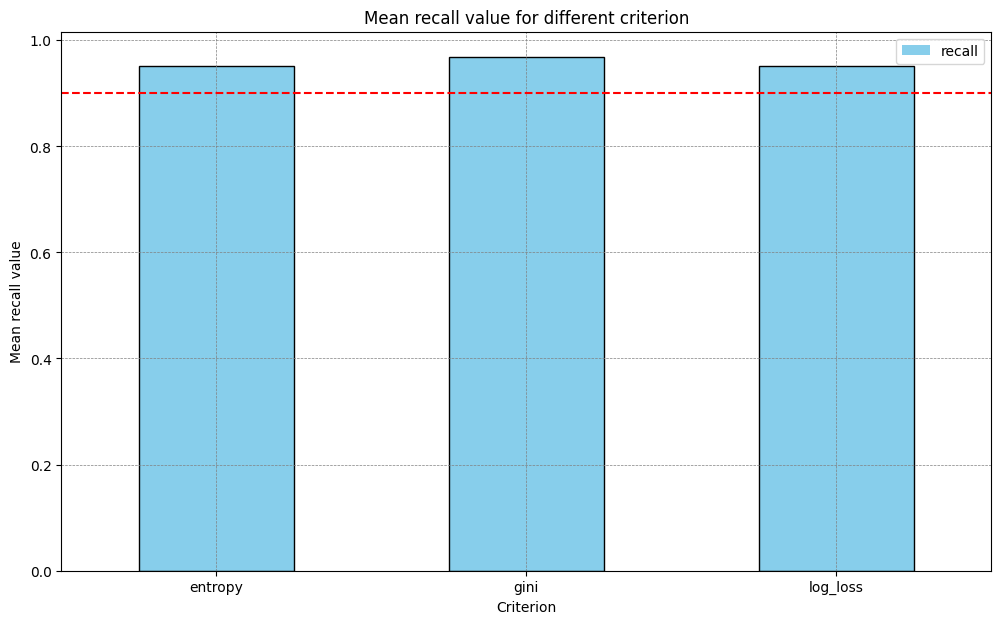

In [53]:
ax = df.plot(x='criterion', y=['recall'], kind='bar', figsize=(12, 7), color='skyblue')
for rect in ax.patches:
    rect.set_edgecolor('black')

plt.title('Mean recall value for different criterion')
plt.xlabel('Criterion')
plt.ylabel('Mean recall value')
plt.axhline(0.9, c='r', label='0.9 threshold', linestyle='--')
plt.xticks(rotation=0)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

### Min Samples Leaf

In [54]:
grid_params = {'tree__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

leaf_search = HalvingGridSearchCV(pipeline, grid_params, cv=cv, scoring='recall', n_jobs=-1, random_state=42)
leaf_search.fit(X_train_clean, y_train_clean['class'])

df = {
    'min_samples_leaf': leaf_search.cv_results_['param_tree__min_samples_leaf'].data,
    'recall': leaf_search.cv_results_['mean_test_score']
}
df = pd.DataFrame(df)
df = df.groupby('min_samples_leaf').mean().reset_index()
display(df)

,min_samples_leaf,recall
0,1,0.982234
1,2,0.959922
2,3,0.973580
3,4,0.921397
4,5,0.951787
5,6,0.914898
6,7,0.920250
7,8,0.909237
8,9,0.904737
9,10,0.899187


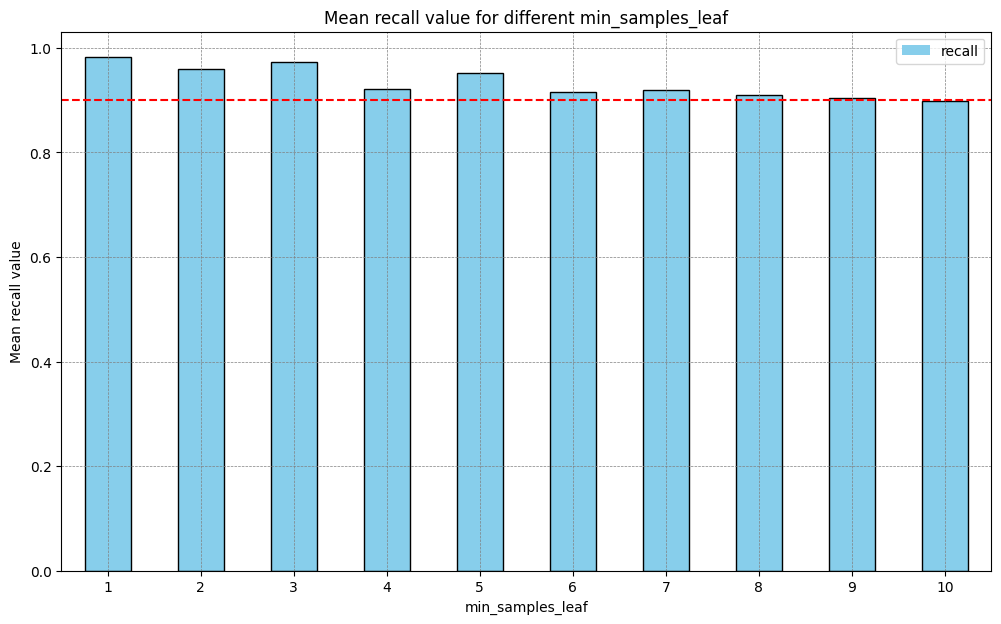

In [55]:
ax = df.plot(x='min_samples_leaf', y='recall', kind='bar', figsize=(12, 7), color='skyblue')
for rect in ax.patches:
    rect.set_edgecolor('black')

plt.title('Mean recall value for different min_samples_leaf')
plt.xlabel('min_samples_leaf')
plt.ylabel('Mean recall value')
plt.axhline(0.9, c='r', label='0.9 threshold', linestyle='--')
plt.xticks(rotation=0)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

### Visualisation for the "autumn" tree

In [56]:
pipeline_copy = clone(pipeline)
pipeline_copy.set_params(tree__min_samples_leaf=500)
pipeline_copy.fit(X_train_clean, y_train_clean['class'])

y_pred = pipeline_copy.predict(X_test_clean)

results['AutumnTree'] = {
    'recall': recall_score(y_test_clean , y_pred, pos_label=1),
    'precision': precision_score(y_test_clean , y_pred, pos_label=1),
    'f1': f1_score(y_test_clean , y_pred, pos_label=1),
    'accuracy': accuracy_score(y_test_clean , y_pred),
    'mcc': matthews_corrcoef(y_test_clean, y_pred)
    }

results_df = pd.DataFrame(results)

display(results_df)

,SimpleTree,PipelineTree,PipelineTreeNoOutliers,ShallowTree,AutumnTree
recall,0.997525,0.999115,0.999107,0.942559,0.804760
precision,0.997624,0.999213,0.999305,0.816895,0.849725
f1,0.997575,0.999164,0.999206,0.875240,0.826632
accuracy,0.997241,0.999072,0.999098,0.850882,0.812674
mcc,0.994376,0.998122,0.998163,0.703274,0.624321


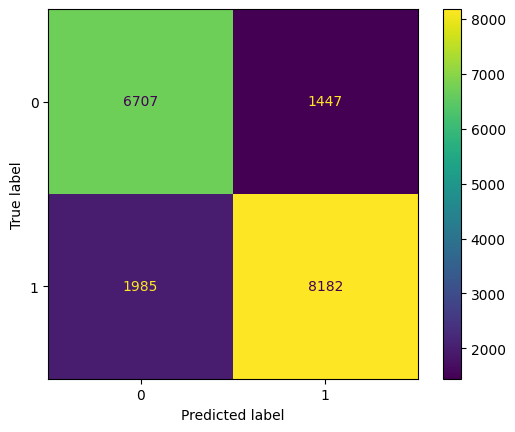

In [57]:
cm = confusion_matrix(y_test_clean, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_copy.named_steps['tree'].classes_)
disp.plot()

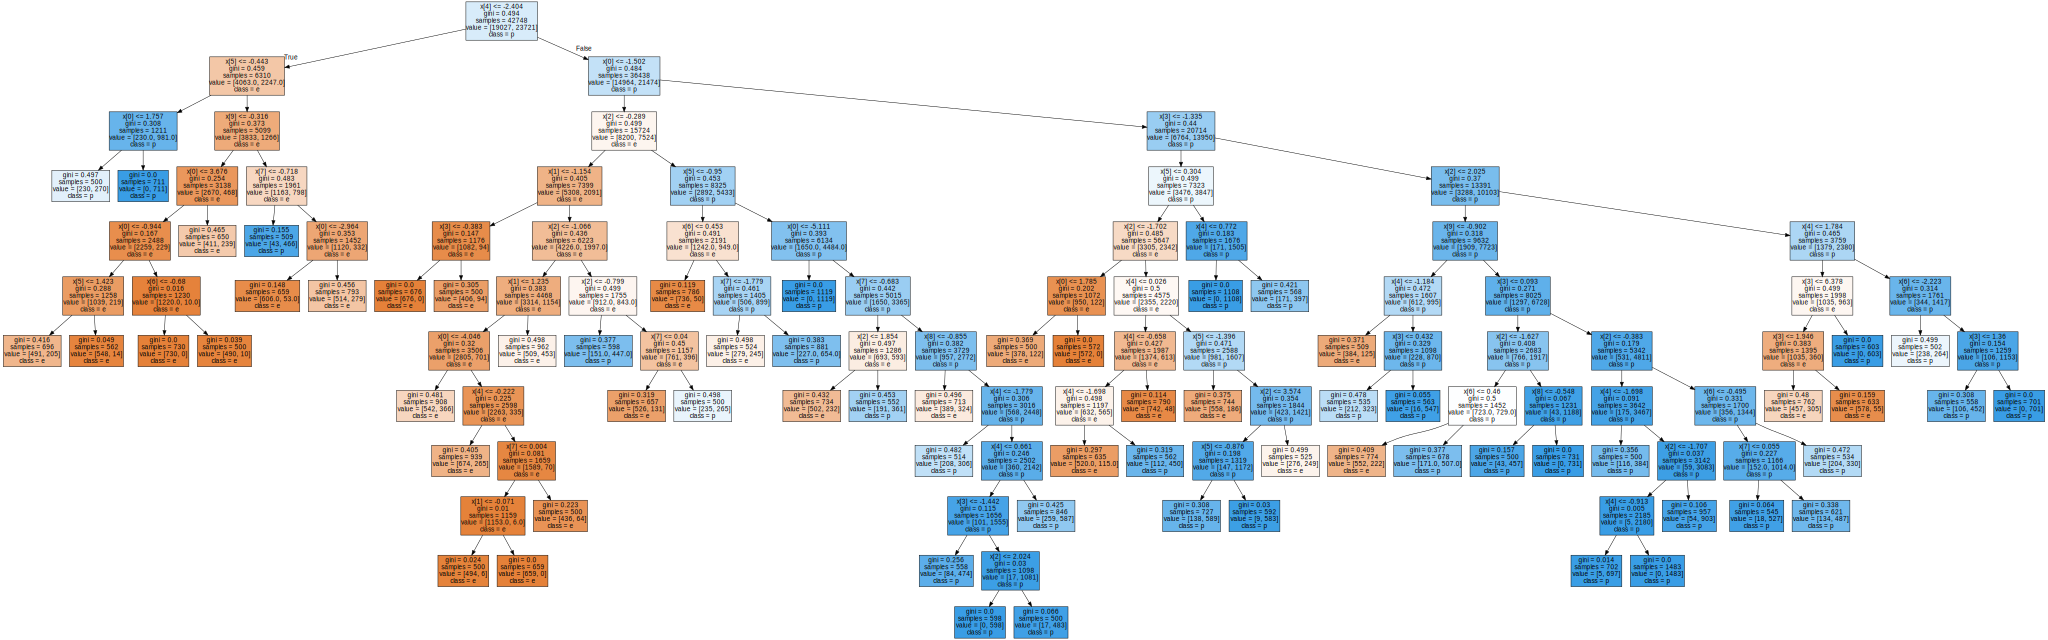

In [58]:
graph_tree = sktree.export_graphviz(pipeline_copy.named_steps['tree'], out_file=None, class_names=['e', 'p'], filled=True)
graph = graphviz.Source(graph_tree, format='png')
display(graph)

### Cpp alpha

In [80]:
grid_params = {'tree__ccp_alpha': [0.0, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05]}

alpha_search = HalvingGridSearchCV(pipeline, grid_params, cv=cv, scoring='recall', n_jobs=-1, random_state=42)
alpha_search.fit(X_train_clean, y_train_clean['class'])

df = {
    'ccp_alpha': alpha_search.cv_results_['param_tree__ccp_alpha'].data,
    'recall': alpha_search.cv_results_['mean_test_score']
}
df = pd.DataFrame(df)
df = df.groupby('ccp_alpha').mean().reset_index()
display(df)

,ccp_alpha,recall
0,0.000,0.991329
1,0.001,0.956865
2,0.010,0.597099
3,0.020,0.912695
4,0.030,1.000000
5,0.040,1.000000
6,0.050,1.000000


### Why you shouldn't believe one metric?

In [95]:
pipeline_copy = clone(pipeline)
pipeline_copy.set_params(tree__ccp_alpha=0.0182)
pipeline_copy.fit(X_train_clean, y_train_clean['class'])

y_pred = pipeline_copy.predict(X_test_clean)

results['PipelineHugeAlfa'] = {
    'recall': recall_score(y_test_clean, y_pred, pos_label=1),
    'precision': precision_score(y_test_clean, y_pred, pos_label=1),
    'f1': f1_score(y_test_clean, y_pred, pos_label=1),
    'accuracy': accuracy_score(y_test_clean, y_pred),
    'mcc': matthews_corrcoef(y_test_clean, y_pred)
    }

results_df = pd.DataFrame(results)

display(results_df)


,SimpleTree,PipelineTree,PipelineTreeNoOutliers,ShallowTree,AutumnTree,PipelineHugeAlfa
recall,0.997525,0.999115,0.999107,0.942559,0.804760,0.812924
precision,0.997624,0.999213,0.999305,0.816895,0.849725,0.667124
f1,0.997575,0.999164,0.999206,0.875240,0.826632,0.732843
accuracy,0.997241,0.999072,0.999098,0.850882,0.812674,0.671088
mcc,0.994376,0.998122,0.998163,0.703274,0.624321,0.326233


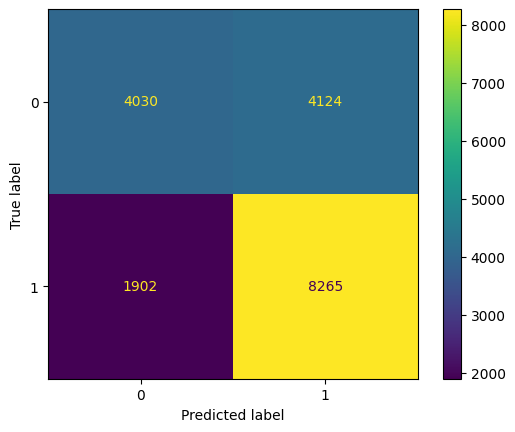

In [96]:
cm = confusion_matrix(y_test_clean, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_copy.named_steps['tree'].classes_)
disp.plot()

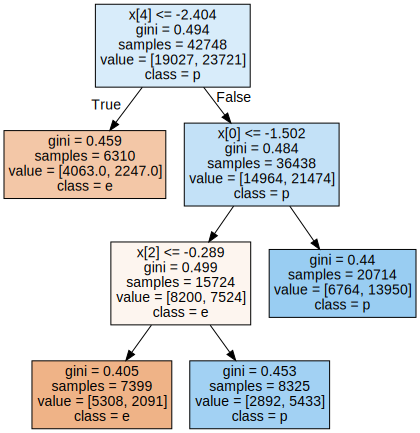

In [97]:
graph_tree = sktree.export_graphviz(pipeline_copy.named_steps['tree'], out_file=None, class_names=['e', 'p'], filled=True)
graph = graphviz.Source(graph_tree, format='png')
display(graph)

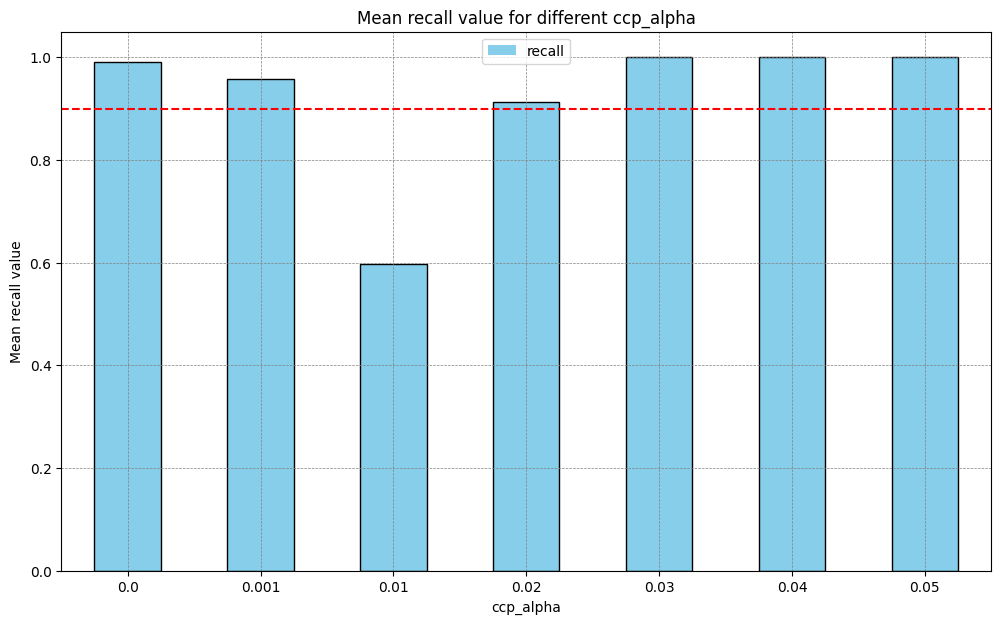

In [98]:
ax = df.plot(x='ccp_alpha', y='recall', kind='bar', figsize=(12, 7), color='skyblue')
for rect in ax.patches:
    rect.set_edgecolor('black')

plt.title('Mean recall value for different ccp_alpha')
plt.xlabel('ccp_alpha')
plt.ylabel('Mean recall value')
plt.axhline(0.9, c='r', label='0.9 threshold', linestyle='--')
plt.xticks(rotation=0)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

## All parameters

In [99]:
grid_params = {
    'tree__max_depth': [9, 11, 13, 15, 17],
    'tree__criterion': ['gini', 'entropy'],
    'tree__min_samples_leaf': [3, 4, 5, 6, 7],
    'tree__ccp_alpha': [0.0, 0.0001, 0.001],    
}

all_search = HalvingGridSearchCV(pipeline, grid_params, cv=cv, scoring='recall',
                                 n_jobs=-1, random_state=42, factor=20)
all_search.fit(X_train_clean, y_train_clean['class'])

df = {
    'params': all_search.cv_results_['params'],
    'recall': all_search.cv_results_['mean_test_score']
}

df = pd.DataFrame(df)
df['params'] = df['params'].map(str)
df = df.groupby('params').mean().reset_index()
df = df.sort_values(by='recall', ascending=False).head(10)
pd.set_option('display.max_colwidth', None)
display(df)

,params,recall
40,"{'tree__ccp_alpha': 0.0, 'tree__criterion': 'gini', 'tree__max_depth': 17, 'tree__min_samples_leaf': 3}",0.942450
90,"{'tree__ccp_alpha': 0.0001, 'tree__criterion': 'gini', 'tree__max_depth': 17, 'tree__min_samples_leaf': 3}",0.942007
15,"{'tree__ccp_alpha': 0.0, 'tree__criterion': 'entropy', 'tree__max_depth': 17, 'tree__min_samples_leaf': 3}",0.939113
65,"{'tree__ccp_alpha': 0.0001, 'tree__criterion': 'entropy', 'tree__max_depth': 17, 'tree__min_samples_leaf': 3}",0.939071
115,"{'tree__ccp_alpha': 0.001, 'tree__criterion': 'entropy', 'tree__max_depth': 17, 'tree__min_samples_leaf': 3}",0.935424
10,"{'tree__ccp_alpha': 0.0, 'tree__criterion': 'entropy', 'tree__max_depth': 15, 'tree__min_samples_leaf': 3}",0.927264
60,"{'tree__ccp_alpha': 0.0001, 'tree__criterion': 'entropy', 'tree__max_depth': 15, 'tree__min_samples_leaf': 3}",0.927242
110,"{'tree__ccp_alpha': 0.001, 'tree__criterion': 'entropy', 'tree__max_depth': 15, 'tree__min_samples_leaf': 3}",0.924185
140,"{'tree__ccp_alpha': 0.001, 'tree__criterion': 'gini', 'tree__max_depth': 17, 'tree__min_samples_leaf': 3}",0.890043
67,"{'tree__ccp_alpha': 0.0001, 'tree__criterion': 'entropy', 'tree__max_depth': 17, 'tree__min_samples_leaf': 5}",0.889103


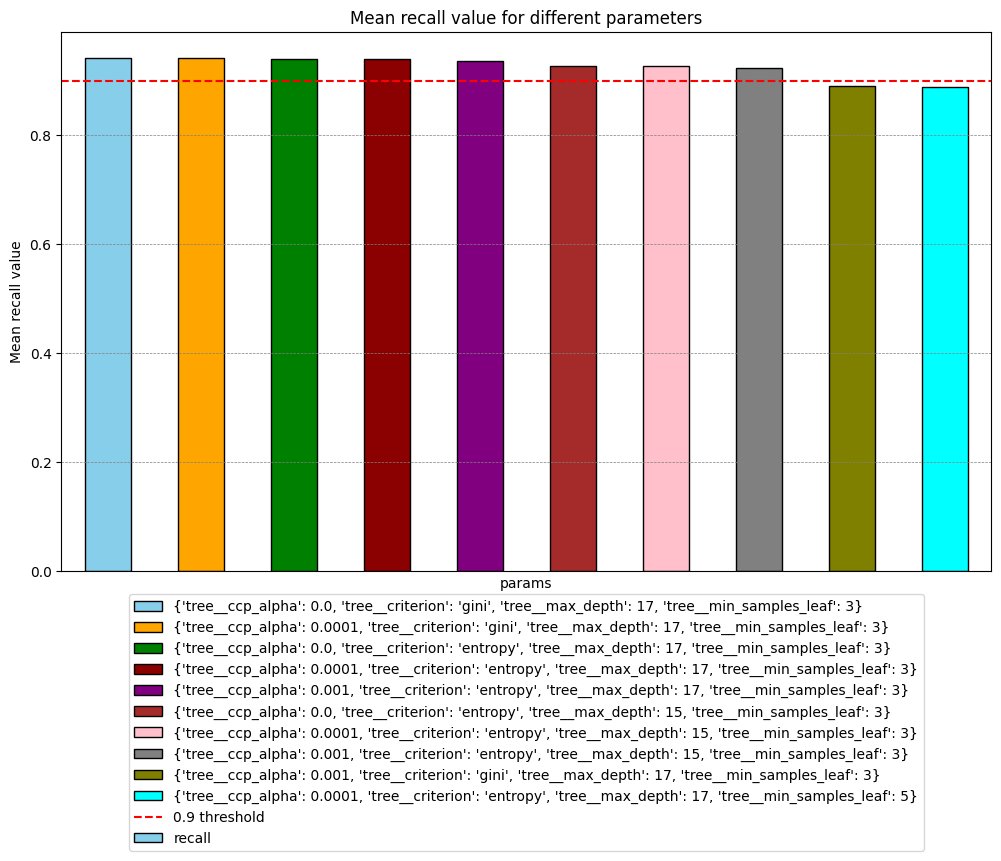

In [100]:
colors = ['skyblue', 'orange', 'green', 'darkred', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
params = df['params'].unique()

ax = df.head(10).plot(x='params', y='recall', kind='bar', figsize=(12, 7), color=colors, legend=False)
for rect, color in zip(ax.patches, colors):
    rect.set_edgecolor('black')
    rect.set_label(params[colors.index(color)])

plt.title('Mean recall value for different parameters')
plt.xlabel('params')
plt.ylabel('Mean recall value')
plt.axhline(0.9, c='r', label='0.9 threshold', linestyle='--')
plt.xticks([])
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.legend(bbox_to_anchor=(0.5, -0.03), loc='upper center')
plt.show()

## Class weight

In [101]:
grid_params = {
    'tree__class_weight': [
        {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 3, 1: 5},
        {0: 1, 1: 5}, {0: 2, 1: 1}, {0: 3, 1: 1},
        ], 'tree__max_depth': [13]
}

weight_search = HalvingGridSearchCV(pipeline, grid_params, cv=cv, scoring='recall',
                                    n_jobs=-1, random_state=42, factor=20)
weight_search.fit(X_train_clean, y_train_clean['class'])

df = {
    'class_weight': weight_search.cv_results_['param_tree__class_weight'],
    'recall': weight_search.cv_results_['mean_test_score']
}

df = pd.DataFrame(df)
df['class_weight'] = df['class_weight'].map(str)
df = df.groupby('class_weight').mean().reset_index()
pd.set_option('display.max_colwidth', None)
display(df.sort_values(by='recall', ascending=False))

,class_weight,recall
2,"{0: 1, 1: 5}",0.995953
1,"{0: 1, 1: 3}",0.995911
0,"{0: 1, 1: 2}",0.989124
5,"{0: 3, 1: 5}",0.986636
3,"{0: 2, 1: 1}",0.884488
4,"{0: 3, 1: 1}",0.805740


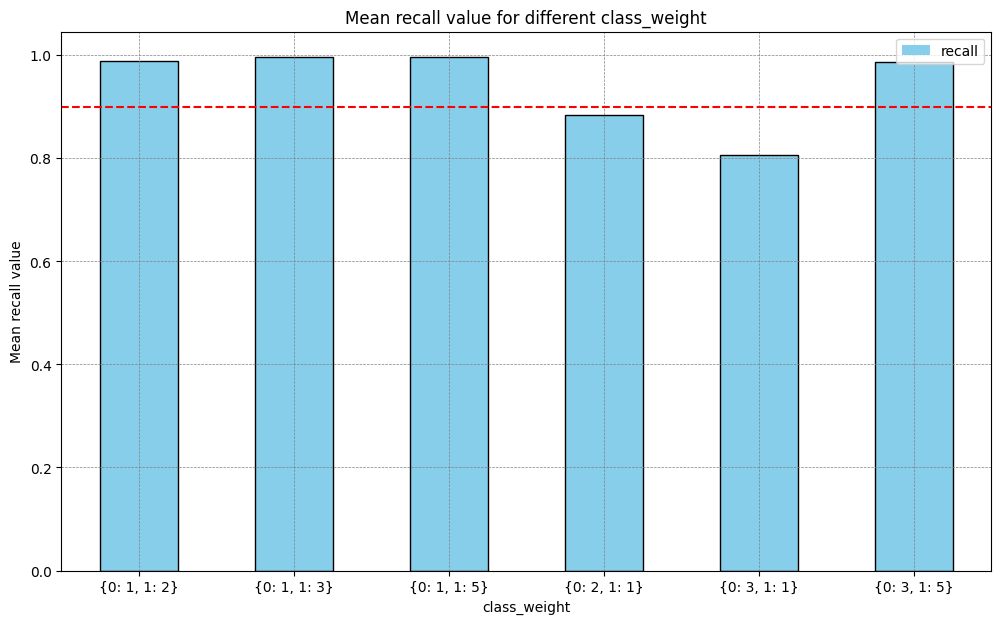

In [102]:
ax = df.plot(x='class_weight', y='recall', kind='bar', figsize=(12, 7), color='skyblue')
for rect in ax.patches:
    rect.set_edgecolor('black')

plt.title('Mean recall value for different class_weight')
plt.xlabel('class_weight')
plt.ylabel('Mean recall value')
plt.axhline(0.9, c='r', label='0.9 threshold', linestyle='--')
plt.xticks(rotation=0)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

### And how the weights weigh on the tree?

In [104]:
pipeline_copy = clone(pipeline)
pipeline_copy.set_params(tree__class_weight={1: 50, 0: 1})
pipeline_copy.fit(X_train_clean, y_train_clean['class'])

y_pred = pipeline_copy.predict(X_test_clean)

results['HeavyTree'] = {
    'recall': recall_score(y_test_clean, y_pred, pos_label=1),
    'precision': precision_score(y_test_clean, y_pred, pos_label=1),
    'f1': f1_score(y_test_clean, y_pred, pos_label=1),
    'accuracy': accuracy_score(y_test_clean, y_pred),
    'mcc': matthews_corrcoef(y_test_clean, y_pred)
    }

results_df = pd.DataFrame(results)

display(results_df)


,SimpleTree,PipelineTree,PipelineTreeNoOutliers,ShallowTree,AutumnTree,PipelineHugeAlfa,HeavyTree
recall,0.997525,0.999115,0.999107,0.942559,0.804760,0.812924,0.998820
precision,0.997624,0.999213,0.999305,0.816895,0.849725,0.667124,0.999606
f1,0.997575,0.999164,0.999206,0.875240,0.826632,0.732843,0.999213
accuracy,0.997241,0.999072,0.999098,0.850882,0.812674,0.671088,0.999127
mcc,0.994376,0.998122,0.998163,0.703274,0.624321,0.326233,0.998233


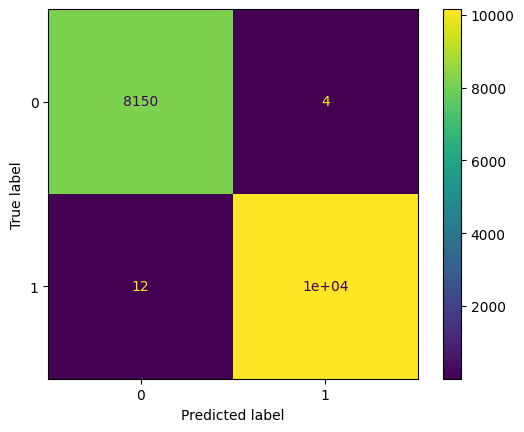

In [105]:
cm = confusion_matrix(y_test_clean, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_copy.named_steps['tree'].classes_)
disp.plot()

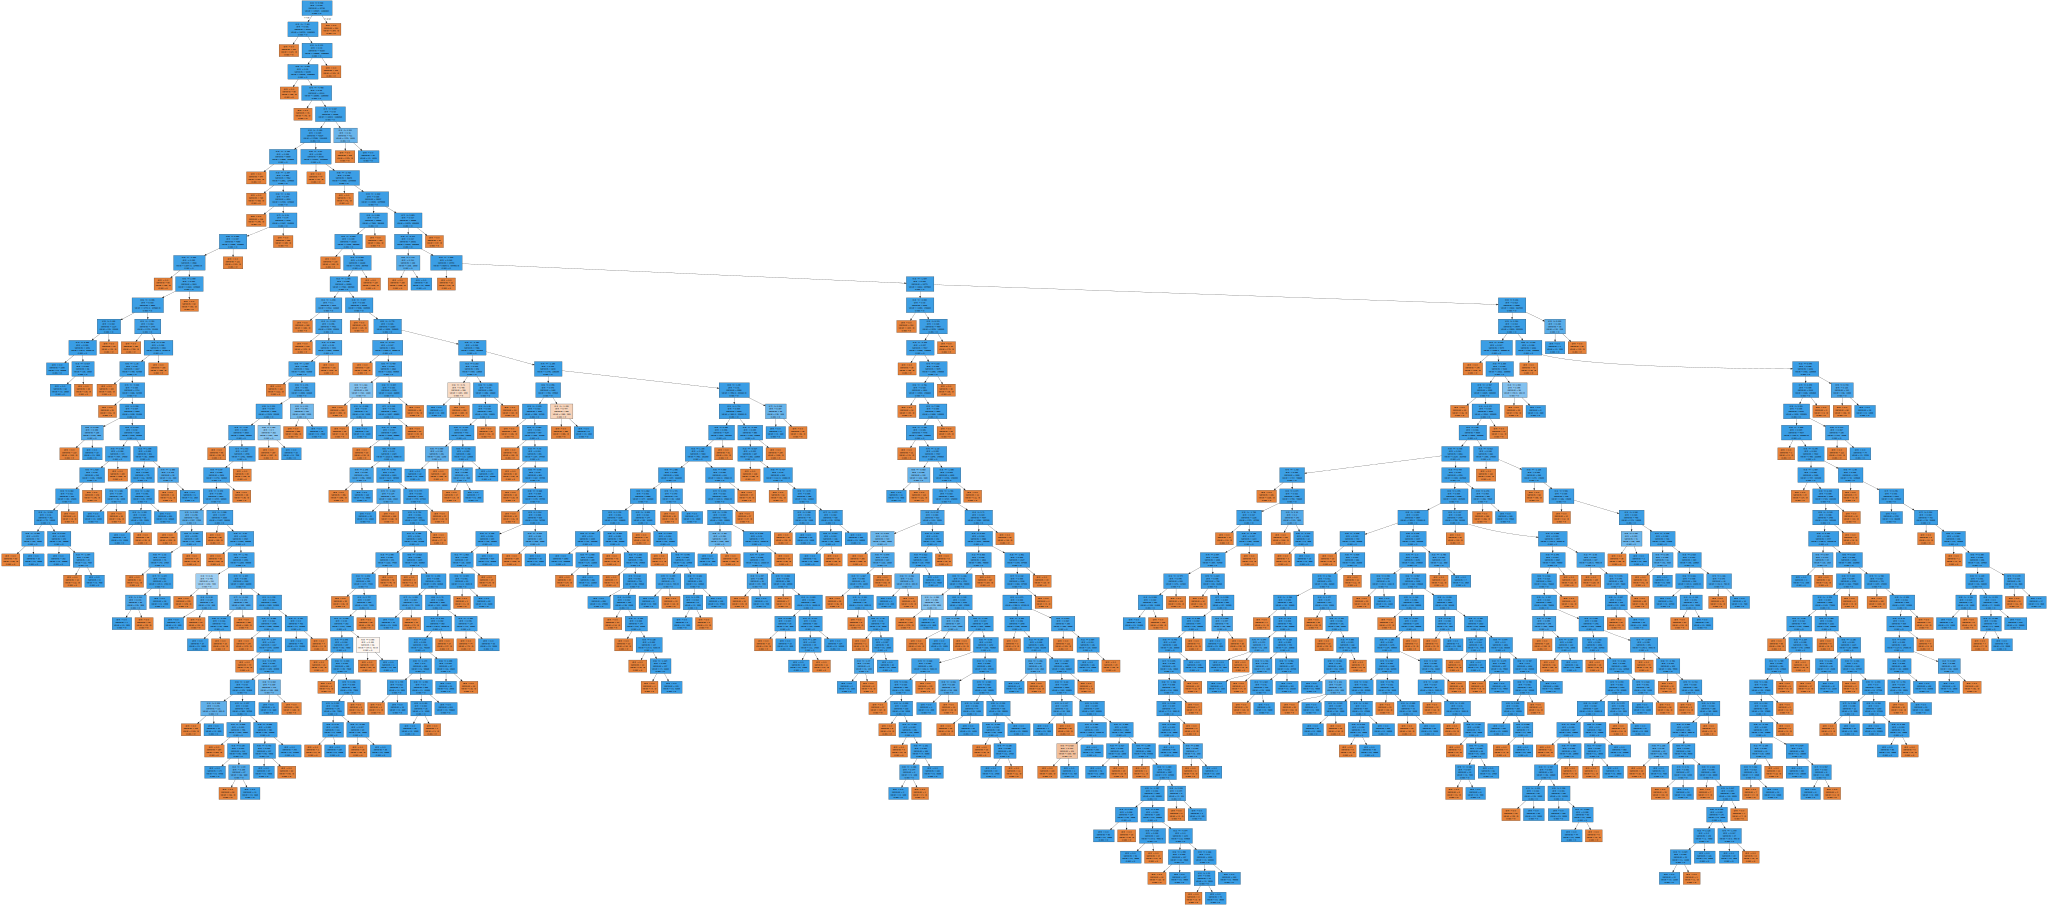

In [106]:
graph_tree = sktree.export_graphviz(pipeline_copy.named_steps['tree'], out_file=None, class_names=['e', 'p'], filled=True)
graph = graphviz.Source(graph_tree, format='png')
display(graph)

## Conclusions and findings

Paremeters and their impact on graphics:
- **You shouldn't believe only one measure**.
- Outliers are important, you can see that they strongly influence the tree,
- `cryterion' - both *gini* and *entropy* are very similar, gini index is calculated faster, but it happens to isolate the most frequent classes. Entropy generates more balanced trees.
- `max_depth` varies the tree, but can continue to be wide,
- `min_samples_leaf` can be seen to make the tree less symmetrical, cores are formed
- `Cpp_alpha` can effectively reduce the tree to a large extent
- `weight` make the tree have many short branches.